In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm
from torchdiffeq import odeint

Function definition for the Van der Pol Oscillator.

In [3]:
y = torch.zeros(2)
y[1] = 1.

u = torch.zeros(1)

mu = 1
f = lambda y, u: torch.stack((y[...,1], mu * (1 - y[...,0]**2) * y[...,1] - y[...,0] + u[...,0]),dim=-1)
f(y,u)

tensor([1., 1.])

Solving using 4th order Runge-Kutta.

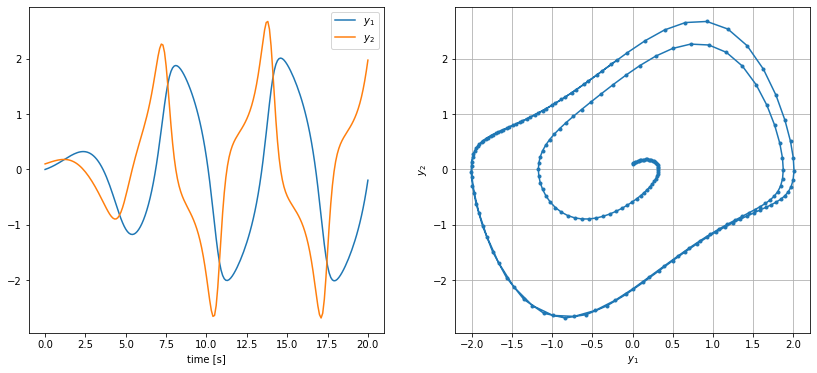

In [15]:
y0 = torch.zeros(2)
y0[1] = .1
u = torch.zeros(1)
dt = 0.1
N = 200
Y_ref = odeint(lambda t, y: f(y,u), y0, torch.Tensor([i * dt for i in range(N+1)]), method='rk4')
Y_ref = Y_ref.detach().numpy()

time = [dt * k for k in range(N+1)]

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,6)

axs[0].plot(time, Y_ref[:,0], label='$y_1$')
axs[0].plot(time, Y_ref[:,1], label='$y_2$')
axs[0].set_xlabel('time [s]')
axs[0].legend()

axs[1].plot(Y_ref[:,0], Y_ref[:,1], marker='.')
axs[1].set_xlabel('$y_1$')
axs[1].set_ylabel('$y_2$')
axs[1].grid()

plt.show()

For our experiments, $u \in [−1, 1]$ and $y_1, y_2 \in [−3, 3]$.

# Data

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
T = 0.5  # sampling time

In [7]:
# TODO: I should generate the data points during training, rather than fixing them beforehand
N_t = 1000
Y_t = torch.rand(N_t,2) * 6 - 3  # State data points for training
U_t = torch.rand(N_t,1) * 2 - 1  # Input data points for training
X_t = torch.cat((torch.zeros(N_t,1),Y_t,U_t), dim=1).to(device)
Y_t = Y_t.to(device)

N_f = 100000
Y_f = torch.rand(N_f,2) * 6 - 3  # State data points for training
U_f = torch.rand(N_f,1) * 2 - 1  # Input data points for training
T_f = torch.rand(N_f,1) * T  # Time data points for training
X_f = torch.cat((torch.zeros(N_f,1),Y_f,U_f), dim=1).to(device)
X_f.requires_grad_()
dY_f = f(Y_f,U_f).to(device)

# Training with Adam

  0%|          | 0/3000 [00:00<?, ?it/s]

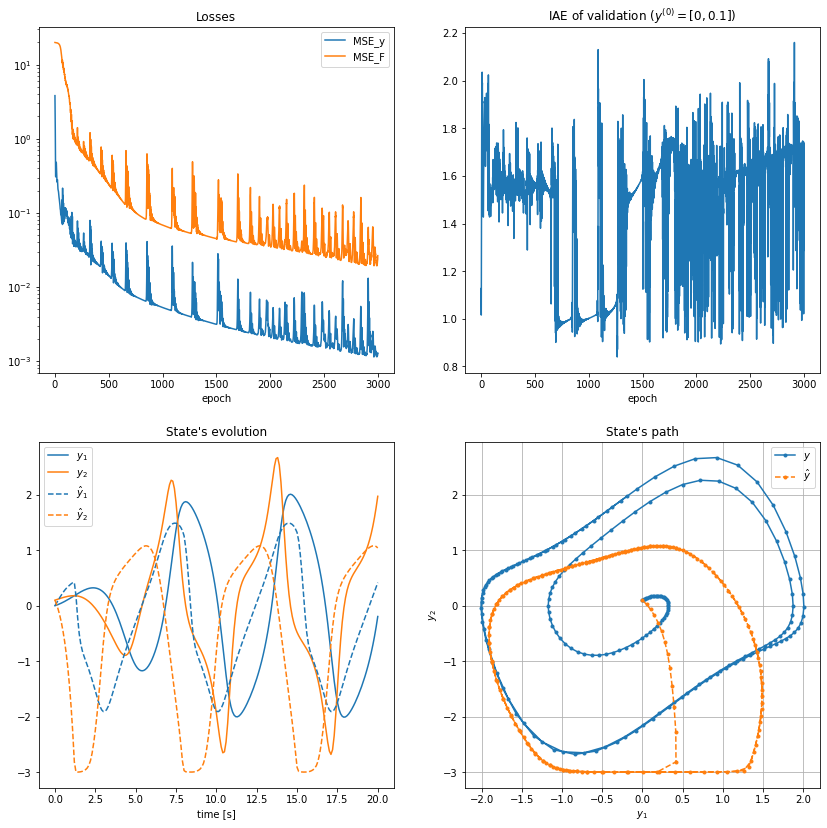

In [153]:
net = torch.nn.Sequential(
    nn.Linear(4,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,2),
    nn.Tanh()
).to(device)
h = lambda y: y * 3  # maps tanh output to state domain

def get_dY_pred(Y_pred, X):
    delY0_pred = torch.autograd.grad(
        Y_pred[:,0],
        X,
        # why does this work? based on https://discuss.pytorch.org/t/gradient-of-scalar-output-w-r-t-input-in-batches/129043
        grad_outputs=torch.ones_like(Y_pred[:,0]),
        retain_graph=True,
        create_graph=True
    )[0][:,0]  # time derivative (first input dimension)

    delY1_pred = torch.autograd.grad(
        Y_pred[:,1],
        X,
        grad_outputs=torch.ones_like(Y_pred[:,1]),
        retain_graph=True,
        create_graph=True
    )[0][:,0]  # time derivative (first input dimension)

    return torch.stack((delY0_pred, delY1_pred), dim=-1)

lamb = .05
mse_y = nn.MSELoss()
mse_F = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.01)

# validation vars
y0 = torch.zeros(1,2).to(device)
y0[0,1] = .1
u = torch.zeros(1,1).to(device)
dt = torch.ones(1,1).to(device) * 0.1
K = 200

y_losses = list()
F_losses = list()
iaes = list()
for e in tqdm(list(range(3000))):
    # Training
    net.train()
    optimizer.zero_grad()

    Y_t_pred = h(net(X_t))

    loss_y = mse_y(Y_t_pred, Y_t)
    y_losses.append(loss_y.item())

    Y_f_pred = h(net(X_f))

    dY_pred = get_dY_pred(Y_f_pred, X_f)

    loss_F = mse_F(dY_pred, dY_f)
    F_losses.append(loss_F.item())

    loss = loss_y + lamb * loss_F
    loss.backward()
    optimizer.step()

    # Validation
    net.eval()
    x = torch.cat((dt,y0,u), dim=-1)
    Y = [y0.cpu().detach().numpy().squeeze(),]
    with torch.no_grad():
        for n in range(K):
            y_next = h(net(x))
            Y.append(y_next.cpu().detach().numpy().squeeze())
            x = torch.cat((dt,y_next,u), dim=-1)
    iaes.append(np.abs(Y_ref - Y).mean())

Y = np.stack(Y)
time = [0.1 * k for k in range(N+1)]

fig, axs = plt.subplots(2,2)
fig.set_size_inches(14,14)

axs[0,0].set_title('Losses')
axs[0,0].semilogy(y_losses, label='MSE_y')
axs[0,0].semilogy(F_losses, label='MSE_F')
axs[0,0].set_xlabel('epoch')
axs[0,0].legend()

axs[0,1].set_title('IAE of validation ($y^{(0)}=[0,0.1]$)')
axs[0,1].plot(iaes, label='IAE')
axs[0,1].set_xlabel('epoch')

axs[1,0].set_title("State's evolution")
axs[1,0].plot(time, Y_ref[:,0], c='tab:blue', label='$y_1$')
axs[1,0].plot(time, Y_ref[:,1], c='tab:orange', label='$y_2$')
axs[1,0].plot(time, Y[:,0], '--', c='tab:blue', label='$\hat{y}_1$')
axs[1,0].plot(time, Y[:,1], '--', c='tab:orange', label='$\hat{y}_2$')
axs[1,0].set_xlabel('time [s]')
axs[1,0].legend()

axs[1,1].set_title("State's path")
axs[1,1].plot(Y_ref[:,0], Y_ref[:,1], marker='.', label='$y$')
axs[1,1].plot(Y[:,0], Y[:,1], '--', marker='.', label='$\hat{y}$')
axs[1,1].set_xlabel('$y_1$')
axs[1,1].set_ylabel('$y_2$')
axs[1,1].legend()
axs[1,1].grid()

plt.show()

# Real training results

In [8]:
from deq_vdp.train import load_from_wandb

/tmp/ipykernel_6587/4167671694.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


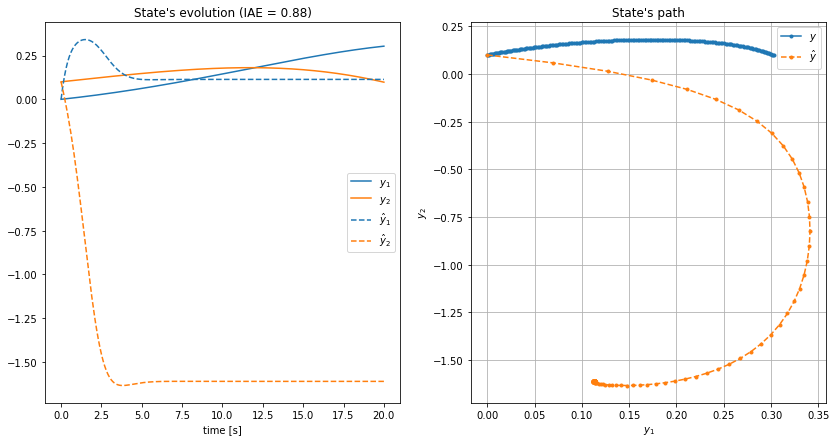

In [14]:
net = nn.Sequential(
    nn.Linear(4,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,2),
    nn.Tanh()
)
h = lambda y: y * 3  # maps tanh output to state domain
net = load_from_wandb(net, '261x5c9o', model_fname='model_last').to(device)
net.eval()

# validation vars
y0 = torch.zeros(1,2).to(device)
y0[0,1] = .1
u = torch.zeros(1,1).to(device)
dt = torch.ones(1,1).to(device) * 0.01
K = 200

x = torch.cat((dt,y0,u), dim=-1)
Y = [y0.cpu().detach().numpy().squeeze(),]
with torch.no_grad():
    for n in range(K):
        y_next = h(net(x))
        Y.append(y_next.cpu().detach().numpy().squeeze())
        x = torch.cat((dt,y_next,u), dim=-1)

iae = np.abs(Y_ref - Y).mean()

Y = np.stack(Y)
time = [0.1 * k for k in range(N+1)]

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,7)

axs[0].set_title(f"State's evolution (IAE = {iae:.2f})")
axs[0].plot(time, Y_ref[:,0], c='tab:blue', label='$y_1$')
axs[0].plot(time, Y_ref[:,1], c='tab:orange', label='$y_2$')
axs[0].plot(time, Y[:,0], '--', c='tab:blue', label='$\hat{y}_1$')
axs[0].plot(time, Y[:,1], '--', c='tab:orange', label='$\hat{y}_2$')
axs[0].set_xlabel('time [s]')
axs[0].legend()

axs[1].set_title("State's path")
axs[1].plot(Y_ref[:,0], Y_ref[:,1], marker='.', label='$y$')
axs[1].plot(Y[:,0], Y[:,1], '--', marker='.', label='$\hat{y}$')
axs[1].set_xlabel('$y_1$')
axs[1].set_ylabel('$y_2$')
axs[1].legend()
axs[1].grid()

fig.show()

/tmp/ipykernel_6587/1140375333.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


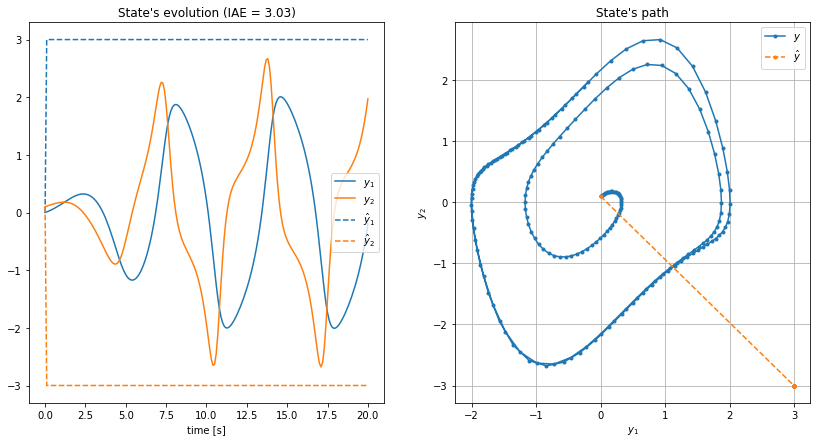

In [19]:
net = nn.Sequential(
    nn.Linear(4,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,2),
    nn.Tanh()
)
h = lambda y: y * 3  # maps tanh output to state domain
net = load_from_wandb(net, 'hddfl7hh', model_fname='model_last').to(device)
net.eval()

# validation vars
y0 = torch.zeros(1,2).to(device)
y0[0,1] = .1
u = torch.zeros(1,1).to(device)
dt = torch.ones(1,1).to(device) * 0.1
K = 200

x = torch.cat((dt,y0,u), dim=-1)
Y = [y0.cpu().detach().numpy().squeeze(),]
with torch.no_grad():
    for n in range(K):
        y_next = h(net(x))
        Y.append(y_next.cpu().detach().numpy().squeeze())
        x = torch.cat((dt,y_next,u), dim=-1)

iae = np.abs(Y_ref - Y).mean()

Y = np.stack(Y)
time = [0.1 * k for k in range(N+1)]

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,7)

axs[0].set_title(f"State's evolution (IAE = {iae:.2f})")
axs[0].plot(time, Y_ref[:,0], c='tab:blue', label='$y_1$')
axs[0].plot(time, Y_ref[:,1], c='tab:orange', label='$y_2$')
axs[0].plot(time, Y[:,0], '--', c='tab:blue', label='$\hat{y}_1$')
axs[0].plot(time, Y[:,1], '--', c='tab:orange', label='$\hat{y}_2$')
axs[0].set_xlabel('time [s]')
axs[0].legend()

axs[1].set_title("State's path")
axs[1].plot(Y_ref[:,0], Y_ref[:,1], marker='.', label='$y$')
axs[1].plot(Y[:,0], Y[:,1], '--', marker='.', label='$\hat{y}$')
axs[1].set_xlabel('$y_1$')
axs[1].set_ylabel('$y_2$')
axs[1].legend()
axs[1].grid()

fig.show()